In [1]:
%matplotlib inline

In [2]:
import gym

# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')
# Reset it, returns the starting frame
screen_sample = env.reset()

In [3]:
import torchvision.transforms as transforms
import numpy                  as np
import torch

In [4]:
frame_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((84, 84)),
    transforms.ToTensor()
])

def preprocess(screen_img):
    # crop numbers and walls
    screen_img = screen_img[35:195, 10:150, :]
    # transpose to torch dimention order
    screen_img = screen_img.transpose((2, 0, 1))
    # to tensor
    screen_img = np.ascontiguousarray(screen_img, dtype=np.float32) / 255.
    screen_img = torch.from_numpy(screen_img)
    # transform an add batch dimention
    screen_img = frame_transform(screen_img).unsqueeze(0).type(torch.cuda.FloatTensor)
    return screen_img

In [5]:
extracted_screen_result = preprocess(screen_sample)

In [6]:
import matplotlib.pyplot as plt

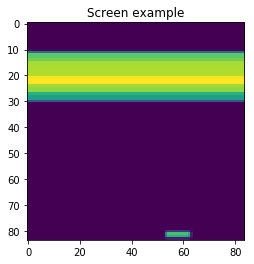

In [7]:
def show_screen(preprocessed_screen):
    plt.figure()
    preprocessed_screen = preprocessed_screen.cpu().squeeze(0).squeeze(0)
    plt.imshow(preprocessed_screen.numpy())
    plt.title('Screen example')
    plt.show()
    
show_screen(extracted_screen_result)

In [8]:
def norm_reward(reward):
    return np.sign(reward)

In [9]:
import torch.nn as nn

In [10]:
class DQN(nn.Module): 
    def __init__(self):
        super(DQN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=8, stride=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
        )

        self.sel = nn.Sequential(
            nn.Linear(9 * 9 * 32, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        out = self.sel(out)
        return out

In [11]:
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Положить переход в память."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """ Получить сэмпл из памяти """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [20]:
Hyperparams = {
    'BATCH_SIZE' : 32,
    'MEMORY_SIZE': 50000,
    'MEM_MIN'    : 64,
    'BACKUP_FREQ': 10000,
    'DISCOUNT'   : 0.99,
    'LR'         : 0.0005,
    'MOMENTUM'   : 0.95,
    'E_START'    : 1.,
    'E_MIN'      : 0.1,
    'E_EXP'      : 100000,
    'NOP_MAX'    : 30,
    'EPISODES'   : 60000
}

In [13]:
import random

def choose_action(state, steps_done):
    sample = random.random()
    eps_treshold = max(Hyperparams['E_MIN'], Hyperparams['E_START'] - \
                       ((Hyperparams['E_MIN'] -  Hyperparams['E_START'])/Hyperparams['E_EXP']) * steps_done)
    if sample > eps_treshold:
        return model(torch.autograd.Variable(state, volatile=True)).type(torch.cuda.FloatTensor).data.max(1)[1].view(1, 1)
    else:
        return torch.cuda.LongTensor([[random.randrange(4)]])

In [14]:
memory    = ReplayMemory(Hyperparams['MEMORY_SIZE'])
model     = DQN().cuda()
backup    = model
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=Hyperparams['LR'], momentum=Hyperparams['MOMENTUM'])

In [15]:
print(model)

DQN(
  (cnn): Sequential(
    (0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU(inplace)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  )
  (sel): Sequential(
    (0): Linear(in_features=2592, out_features=256, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [16]:
from torch.autograd import Variable
from time import sleep

def optimize_model():
    # выбираем новый батч
    transitions = memory.sample(Hyperparams['BATCH_SIZE'])
    
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.cuda.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))

    # Блокируем прохождение градиента для вычисления функции ценности действия
    # volatile=True
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]), volatile=True)
    
    state_batch = Variable(torch.cat(batch.state)).cuda()
    action_batch = Variable(torch.cat(batch.action)).cuda()
    print(action_batch.shape)
    reward_batch = Variable(torch.cat(batch.reward)).cuda()

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колоки, которые соответствуют нашим действиям на щаге
    
    state_action_values = model(state_batch)#.gather(1, action_batch)
    print(state_action_values.shape)
    state_action_values = state_action_values.gather(1, action_batch)
    
    sleep(100000)
    
    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = Variable(torch.zeros(Hyperparams['BATCH_SIZE']).type(torch.cuda.FloatTensor))
    next_state_values[non_final_mask] = backup(non_final_next_states).max(1)[0] # берем значение максимума
    
    # Для подсчета лоса нам нужно будет разрешить прохождение градиента по переменной
    # блокировку, которого мы унаследовали
    # requires_grad=False
    next_state_values.volatile = False
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * Hyperparams['DISCOUNT']) + reward_batch

    # Считаем ошибку Huber loss
    loss = torch.nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [17]:
avg_scores = []
scores     = []
log_freq   = 500

In [18]:
import pickle as pkl
from itertools   import count

In [21]:
steps_done = 0
for i_episode in range(Hyperparams['EPISODES']):
    
    first_action = torch.cuda.LongTensor([[env.action_space.sample()]])
    obs = env.reset()
    
    screen = preprocess(obs)
    
    prev_state = torch.zeros(1, 4, 84, 84).cuda()
    
    ep_reward = 0
    
    for i in range(4):
        #env.render()
        obs, t_rew, done, _ = env.step(first_action[0][0])
        ep_reward += t_rew
        prev_state[:, i:i+1, :, :]  = preprocess(obs)
    
    state = prev_state
    
    for t in count():
        action = choose_action(state, steps_done)
        reward = 0
        done   = False
        next_state = torch.zeros(1, 4, 84, 84).cuda()
    
        for i in range(4):
            #env.render()
            obs, t_rew, t_done, _ = env.step(action[0][0])
            reward += t_rew
            ep_reward += t_rew
            done = done or t_done
            if done:
                next_state = None
                break
            next_state[:, i:i+1, :, :]  = preprocess(obs)
        
        reward = norm_reward(reward)
        reward = torch.cuda.FloatTensor([int(reward)])
        
        memory.push(state, action, next_state, reward)

        # Переходим в новое состояние
        state = next_state
        steps_done += 1
        if steps_done % Hyperparams['BACKUP_FREQ'] == 0:
            #print("Backup done")
            backup = model
        # Шаг оптимизации 
        if len(memory) >= Hyperparams['MEM_MIN']:
            optimize_model()
        if done:
            scores.append(ep_reward)
            if i_episode % log_freq == 0:
                avg_scores.append(sum(scores)/len(scores))
                scores = []
                print("Ep {0:6d}, avg {1:.2f}, steps {2}".format(i_episode, avg_scores[len(avg_scores) - 1], steps_done))
                with open('dqn.pkl'.format(i_episode), 'wb') as f:
                    pkl.dump(model, f)
        
            break

print('Complete')

torch.Size([32, 1])
torch.Size([32, 4])


KeyboardInterrupt: 

In [ ]:
with open('dqn_final.pkl', 'wb') as f:
    pkl.dump(model, f)